In [1]:
import os
import pandas as pd
from MulticoreTSNE import MulticoreTSNE as TSNE
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
!mkdir -p sandbox_am #let's put all stuff in the sandbox
os.chdir("sandbox_am")

### Download a sample of ActinoMock Nanopore data

The sample file is at [https://drive.google.com/uc?id=1rkbbl9zn-3M6qYljRNH-iJ_qOLcF5Q56](https://drive.google.com/uc?id=1rkbbl9zn-3M6qYljRNH-iJ_qOLcF5Q56). Here use gdown to download it or just download it manually

In [9]:
!pip install gdown

In [11]:
if not os.path.exists('ActinoMock_Nanopore.seq.gz'):
    !gdown https://drive.google.com/uc?id=1rkbbl9zn-3M6qYljRNH-iJ_qOLcF5Q56

Downloading...
From: https://drive.google.com/uc?id=1rkbbl9zn-3M6qYljRNH-iJ_qOLcF5Q56
To: /mnt/lshvec/notebook/sandbox_am/ActinoMock_Nanopore.seq.gz
480MB [00:06, 71.9MB/s] 


In [12]:
!cat ActinoMock_Nanopore.seq.gz | gunzip > data.seq

### encode  reads

In [13]:
!python ../../scripts/fastseq/hashSeq.py -i data.seq --hash lsh -o data.hash -k 15 --hash_size 25 --bucket 67108864 > /dev/null  2> error.log

### train a model

In [14]:
#change epoch to 1 to save time
!../../lshvec skipgram -input data.hash -output model  -epoch 5 -dim 100 -lr 0.1

Progress: 100.0% words/sec/thread:   55323 lr:  0.000000 loss:  0.077862 ETA:   0h 0m 0m 0.077870 ETA:   0h 0m 0mh 0mh 0m  0h 0m  0h 0m  0h 0m  0h 0m  0h 0mmm  0h 0m 0m


### Now the model is trained.  To visualize it, first get vectors of reads. 

In [15]:
def read_embedding(fname):
    with open(fname) as fin:
        lines=list(fin)
    assert len(lines)>1
    first_line=lines[0]
    num_word, dim_vec = [int(u) for u in first_line.split(" ")]
    assert len(lines)==num_word+1
    ret ={}
    for line in lines[1:]:
        lst = line.strip().split(" ")
        assert len(lst)==dim_vec+1, line
        if lst[0]=='</s>': continue
        word = int(lst[0])
        vec = np.array([float(u) for u in lst[1:]])
        ret[word]=vec
    return ret,dim_vec

embedding,dim_vec = read_embedding("model.vec")
seqvectors = []
lines=[]
with open("data.hash") as fin:
    for line in fin:
        if len(lines)>=20000: break  #The data is already shuffled, so just take a few from head
        lines.append(line)
for i,line in enumerate(lines):
    words = [int(u) for u in line.strip().split(" ")]
    vec = [embedding[u] for u in words if u in embedding]
    seqvectors.append(np.mean(vec,0) if len(vec)>0 else None)#np.zeros([dim_vec],dtype=np.float32))
    #if i>10: break    

### Next get the labels

In [16]:
seqs = pd.read_csv("data.seq",sep='\t', header=None, usecols=[0,1],index_col=0, nrows=20000)
seqs.columns=['id']
seqs['organism']=seqs['id'].map(lambda u: u.split('-')[1])
seqs['class']=seqs['id'].map(lambda u: u.split('-')[2])
seqs['phylum']=seqs['id'].map(lambda u: u.split('-')[3])
seqs['vec']=seqvectors
seqs.head()

,id,organism,class,phylum,vec
0,,,,,
47914,47914-2616644829-Gammaproteobacteria-Proteobac...,2616644829,Gammaproteobacteria,Proteobacteria,"[-0.13442279161470772, 0.15240311496989598, -0..."
78419,78419-2623620618-Gammaproteobacteria-Proteobac...,2623620618,Gammaproteobacteria,Proteobacteria,"[-0.13671470468108618, 0.18107457278522057, -0..."
67045,67045-2623620617-Gammaproteobacteria-Proteobac...,2623620617,Gammaproteobacteria,Proteobacteria,"[-0.16628105752122976, 0.20923784016426483, -0..."
27710,27710-2615840601-Alphaproteobacteria-Proteobac...,2615840601,Alphaproteobacteria,Proteobacteria,"[-0.1422055522867676, 0.17532996990543492, -0...."
31701,31701-2615840697-Gammaproteobacteria-Proteobac...,2615840697,Gammaproteobacteria,Proteobacteria,"[-0.12411733716978607, 0.1685502147393204, -0...."


### Now train TSNE

In [17]:
tsne = TSNE(n_components=2, perplexity=100, n_jobs=8)
X=np.array(list(seqs['vec'].values))
X.shape

(20000, 100)

In [18]:
%time Y = tsne.fit_transform(X)

CPU times: user 5min 16s, sys: 86.3 ms, total: 5min 16s
Wall time: 1min 1s


### visualization

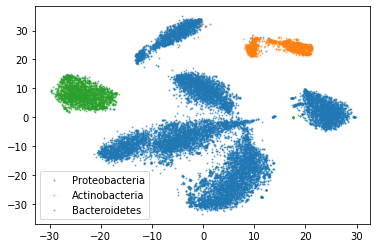

In [19]:
labels=seqs['phylum'].values
legends=list(set(labels))
for label in legends:            
    plt.scatter(Y[labels==label][:,0],Y[labels==label][:,1],alpha=0.5,s=1)
plt.legend(legends)

['Alphaproteobacteria', 'Gammaproteobacteria', 'Actinobacteria', 'Flavobacteriia']


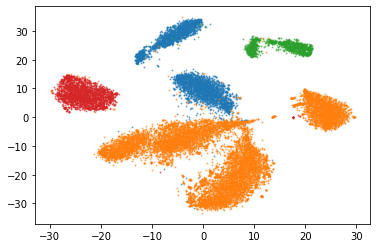

In [20]:
labels=seqs['class'].values
legends=list(set(labels))
print (legends)
for label in legends:            
    plt.scatter(Y[labels==label][:,0],Y[labels==label][:,1],alpha=0.5,s=1)

['2615840697', '2623620617', '2615840646', '2615840533', '2623620557', '2615840527', '2617270709', '2615840601', '2623620567', '2616644829', '2623620618']


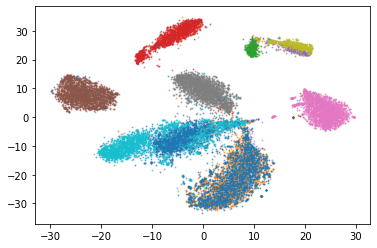

In [21]:
labels=seqs['organism'].values
legends=list(set(labels))
print (legends)
for label in legends:            
    plt.scatter(Y[labels==label][:,0],Y[labels==label][:,1],alpha=0.5,s=1)